<a href="https://colab.research.google.com/github/pasinskik/mimuw/blob/main/HW4_dqn_exploration_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploration strategies for DQN algorithm

> Dodaj cytat blokowy



In this assignment we are interested in exploration strategies that can be combined with Q-learning.
Q-learning is an off-policy algorithm, which means that the data for the algorithm can be collected by a different policy (called behavioural policy) that the one the algorithm learns.

Here we come across a classical trade-off in reinforcement learning, called exploration-exploitation trade-off. On the one hand, our behavioural policy should try out new state-action pairs to gain knowledge about their returns. On the other hand, when our estimate of returns is good enough, we would like to follow the state-action pairs with the highest estimated returns.

We will be operating on DQN [(Mnih 2014)](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) algorithm and analyzing epsilon-greedy strategy, boltzmann and max-boltzmann strategy and combination of epsilon-greedy and boltzmann.
We evaluate performance of DQN variants on the Lunar Lander environment.

We provide an implementation of the DQN algorithm with random exploration strategy.
Your goal is to implement the exploration variants by overriding appropriate methods of the provided class.


## Grading

To obtain the points for the assignment You need to provide the implementation of exploration techniques AND report with plots and conclusions.
Measuring sensitivity means that You should at least examine one reasonably lower and one reasonably greater value of the considered hyperparameter (or the pair of hyperparameters).


1. Implement epsilon-greedy strategy and investigate hyperparameter sensitivity (1 point).
2. Implement epsilon-greedy strategy with epsilon annealing and investigate hyperparameter sensitivity (1 point).
3. Implement boltzmann strategy and investigate hyperparameter sensitivity (1 point).
4. Implement boltzmann strategy with temperature annealing and investigate hyperparameter sensitivity (1 point).
5. Implement max-boltzmann strategy and investigate hyperparameter sensitivity (1 point).
6. Implement max-boltzmann strategy with temperature annealing and investigate hyperparameter sensitivity (1 point).
7. Implement combination of epsilon-greedy with epsilon annealing and boltzmann strategy and investigate hyperparameter sensitivity (1 point)
8. (*) Bonus: propose another reasonable approach to combine epsilon-greedy with epsilon annealing strategy and boltzmann strategy and/or another reasonable strategy of temperature annealing for the boltzmann strategy (2 points).
9. Compare methods, present plots and conclusions in a clear manner (3 points).

You can obtain max 10 points, bonus points increase Your score, if You lose points in some other tasks.

Here we import necessary libraries.

In [29]:
!apt-get install swig
!pip install gymnasium[box2d]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [3]:
import torch
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

Here we set hyperparameters of the training, set seeds for reproducibility and set weights initialization.
Although for debugging it might be useful to operate on a smaller number of training_steps, seeds etc., in the final evaluation DO NOT CHANGE these parameters.

In [13]:
class parse_args:
  def __init__(self):
    self.n_seeds = 6
    self.n_evaluate_episodes = 5
    self.n_training_steps = 100000
    self.buffer_size = 10000
    self.init_steps = 10000
    self.target_update_freq = 50
    self.eval_freq = 1000
    self.gym_id = "LunarLander-v3"
    env = gym.make(self.gym_id)
    self.state_dim = env.observation_space.shape[0]
    self.batch_size = 128
    self.hidden_dim = 128
    self.action_dim = env.action_space.n
    self.discount = 0.99
    self.lr = 7e-4
    self.cuda = True
    self.device = torch.device("cuda" if torch.cuda.is_available() and self.cuda else "cpu")

args = parse_args()
first_half_training_args = parse_args()
first_half_training_args.n_training_steps = first_half_training_args.n_training_steps // 2
second_half_training_args = parse_args()
second_half_training_args.n_training_steps = second_half_training_args.n_training_steps // 2
second_half_training_args.init_steps = 1

In [7]:
def set_seed(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)

def weight_init(model):
  torch.nn.init.orthogonal_(model.weight.data)
  model.bias.data.fill_(0.0)

Here we implement the replay buffer.
It has two methods: add one transition to the buffer and sample batch of transitions from the buffer.

In [8]:
class ReplayBuffer:
  def __init__(self, args):
    self.states = np.zeros((args.buffer_size, args.n_seeds, args.state_dim), dtype = np.float32)
    self.actions = np.zeros((args.buffer_size, args.n_seeds), dtype = np.int64)
    self.rewards = np.zeros((args.buffer_size, args.n_seeds), dtype = np.float32)
    self.next_states = np.zeros((args.buffer_size, args.n_seeds, args.state_dim), dtype = np.float32)
    self.terminals = np.zeros((args.buffer_size, args.n_seeds), dtype = np.int64)
    self.idx = 0
    self.current_size = 0
    self.args = args

  def add(self, state, action, reward, next_state, terminal):
    if self.current_size < self.args.buffer_size:
      self.current_size += 1
    self.states[self.idx, :, :] = state
    self.actions[self.idx, :] = action
    self.rewards[self.idx, :] = reward
    self.next_states[self.idx, :, :] = next_state
    self.terminals[self.idx, :] = terminal
    self.idx = (self.idx + 1) % self.args.buffer_size

  def sample(self):
    sample_idxs = np.random.permutation(self.current_size)[:self.args.batch_size]
    states = torch.from_numpy(self.states[sample_idxs]).to(self.args.device)
    actions = torch.from_numpy(self.actions[sample_idxs]).to(self.args.device)
    rewards = torch.from_numpy(self.rewards[sample_idxs]).to(self.args.device)
    next_states = torch.from_numpy(self.next_states[sample_idxs]).to(self.args.device)
    terminals = torch.from_numpy(self.terminals[sample_idxs]).to(self.args.device)

    return states, actions, rewards, next_states, terminals


Here we implement a simple Q network architecture with three layers and ReLU activations.

In [9]:
class QNetwork(torch.nn.Module):
  def __init__(self, args):
    super(QNetwork, self).__init__()
    self.layer_1 = torch.nn.Linear(args.state_dim, args.hidden_dim)
    self.layer_2 = torch.nn.Linear(args.hidden_dim, args.hidden_dim)
    self.layer_3 = torch.nn.Linear(args.hidden_dim, args.action_dim)
    self.relu = torch.nn.ReLU()

    self.layer_1.apply(weight_init)
    self.layer_2.apply(weight_init)
    self.layer_3.apply(weight_init)

  def forward(self, x):
    x = self.relu(self.layer_1(x))
    x = self.relu(self.layer_2(x))
    x = self.layer_3(x)

    return x

Here we provide code for DQN with random exploration.

In [10]:
TRAIN_SEED = 0
EVAL_SEED = 1

class DQN:
  def __init__(self, args):
    self.args = args
    self.discount = self.args.discount
    self.reset()
    self.annealing = False

  # Copying parameters of other DQN class by reference (for half epsion-greedy, half boltzmann task)
  def copy_reference(self, other):
    self.buffer = other.buffer
    self.q_net = other.q_net
    self.q_target = other.q_target
    self.optimizer = other.optimizer

  # Annealing of epsilon and/or temperature
  def anneal(self, step):
    pass

  # Greedy action
  def get_greedy_action(self, states):
    with torch.no_grad():
      action = torch.argmax(self.q_net(states), dim = -1).detach().cpu().numpy()
      return action

  # Exploration action choice
  def explore(self, states):
    # Random action choice
    action = np.random.randint(self.args.action_dim, size = self.args.n_seeds)
    return action

  # Update of the main critic
  def update(self):
    states, actions, rewards, next_states, terminals = self.buffer.sample()
    with torch.no_grad():
      q_next_states = torch.max(self.q_target(next_states), dim = -1)[0]
    ones_tensor = torch.ones_like(terminals).to(self.args.device)
    targets = rewards + (ones_tensor - terminals) * self.discount * q_next_states

    self.optimizer.zero_grad()
    q_values = self.q_net(states).gather(-1, actions.unsqueeze(-1)).squeeze(-1)
    loss = torch.mean((q_values - targets) ** 2)
    loss.backward()
    self.optimizer.step()

  # Update of the targer critic
  def update_target(self):
    self.q_target.load_state_dict(self.q_net.state_dict())

  # Evaluation of the performance on test environments.
  def evaluate(self):
    eval_results = np.zeros(self.args.n_seeds)
    with torch.no_grad():
      eval_env = gym.make_vec(self.args.gym_id, num_envs = self.args.n_seeds, vectorization_mode="sync")
      eval_env.reset(seed = EVAL_SEED)
      for _ in range(self.args.n_evaluate_episodes):
        state, info = eval_env.reset()
        episode_reward = np.zeros(self.args.n_seeds)
        mask = np.ones(self.args.n_seeds)
        while np.sum(mask) > 0:
          action = self.get_greedy_action(torch.tensor(state).to(self.args.device))
          next_state, reward, terminal, truncated, _ = eval_env.step(action)
          episode_reward += mask * reward
          state = next_state
          mask *= (np.ones(self.args.n_seeds) - terminal) * (np.ones(self.args.n_seeds) - truncated)
        eval_results += episode_reward / self.args.n_evaluate_episodes
    return np.mean(eval_results), np.std(eval_results)


  # Resetting the algorithm
  def reset(self):
    self.buffer = ReplayBuffer(self.args)
    self.q_net = QNetwork(self.args).to(self.args.device) # main critic
    self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr = self.args.lr, eps = 1e-5)
    self.q_target = QNetwork(self.args).to(self.args.device) # target critic
    self.update_target()

  # Training loop
  def train(self):
    eval_results_means = np.array([])
    eval_results_stds = np.array([])
    train_env = gym.make_vec(self.args.gym_id, num_envs = self.args.n_seeds, vectorization_mode="sync")
    state, info = train_env.reset(seed = TRAIN_SEED)
    mask = np.ones(self.args.n_seeds)
    for step in range(self.args.n_training_steps):
      action = self.explore(torch.tensor(state).to(self.args.device)) # Removed .unsqueeze(0)
      if self.annealing:
        self.anneal(step)
      next_state, reward, terminal, truncated, _ = train_env.step(action)
      self.buffer.add(state, action, reward, next_state, terminal)
      state = next_state
      if step % self.args.eval_freq == 0:
          print(f"Training step: {step}")
          eval_mean, eval_std = self.evaluate()
          print(f"Eval mean: {eval_mean}; eval_std: {eval_std}")
          eval_results_means = np.append(eval_results_means, eval_mean)
          eval_results_stds = np.append(eval_results_stds, eval_std)
      if step >= self.args.init_steps:
        self.update()
        if step % self.args.target_update_freq == 0:
          self.update_target()
      mask *= (np.ones(self.args.n_seeds) - terminal) * (np.ones(self.args.n_seeds) - truncated)
      if np.sum(mask) == 0:
        state, info = train_env.reset()
        mask = np.ones(self.args.n_seeds)

    return eval_results_means, eval_results_stds

Here we implement functions for plotting.

In [11]:
def smooth(data, weigth = 0.9):
  smooth_data = np.copy(data)
  for index in range(1, len(data)):
    smooth_data[index] = smooth_data[index - 1] * weigth + data[index] * (1.0 - weigth)

  return smooth_data

def plot_smooth(args, result_means, result_stds):
  smooth_result_means = smooth(result_means)
  smooth_result_stds = smooth(result_stds)
  print(smooth_result_means)
  print(smooth_result_stds)
  xs = np.arange(len(result_means)) * args.eval_freq
  print(xs)
  plt.plot(xs, smooth_result_means, color = "blue")
  plt.fill_between(xs, smooth_result_means - smooth_result_stds, smooth_result_means + smooth_result_stds, alpha = 0.2, label = "smoothed_rewards")
  plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
  plt.show()
  plt.clf()

def plot_smooth_many(args, result_means_list, result_stds_list, names_list, colours_list):
  plt.figure(figsize=(12.8, 9.6))
  for result_means, result_stds, name, colour in zip(result_means_list, result_stds_list, names_list, colours_list):
    smooth_result_means = smooth(result_means)
    smooth_result_stds = smooth(result_stds)
    print(smooth_result_means)
    print(smooth_result_stds)
    xs = np.arange(len(result_means)) * args.eval_freq
    print(xs)
    plt.plot(xs, smooth_result_means, color = colour)
    plt.fill_between(xs, smooth_result_means - smooth_result_stds, smooth_result_means + smooth_result_stds, alpha = 0.2, color = colour, label = f"smoothed_rewards_{name}")
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
  plt.show()
  plt.clf()

def plot_results(result_mean, result_std):
  plot_smooth(args, result_mean, result_std)

def plot_results_many(result_means_list, result_stds_list, name_list, colours_list):
  plot_smooth_many(args, result_means_list, result_stds_list, name_list, colours_list)

Here we provide code for training across different random seeds.

In [12]:
def train_dqn(dqn):
  set_seed(TRAIN_SEED)
  dqn.reset()
  result_mean, result_std = dqn.train()
  print(result_mean)
  return result_mean, result_std


Training step: 0
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 1000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 2000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 3000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 4000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 5000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 6000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 7000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 8000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 9000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 10000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 11000
Eval mean: -92.09635353225616; eval_std: 7.427149523591686
Training step: 12000
Eval mean: -139.72535441078307; 

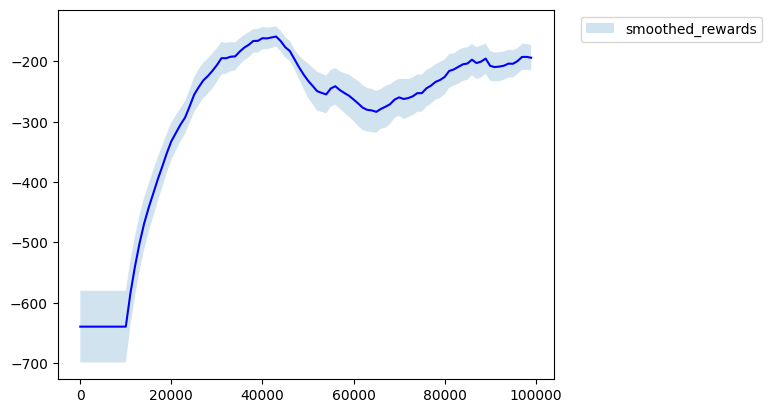

<Figure size 640x480 with 0 Axes>

In [39]:
dqn = DQN(args)
result_means_dqn, result_stds_dqn = train_dqn(dqn)
plot_results(result_means_dqn, result_stds_dqn)

Here the goal is to implement the epsilon-gredy strategy. With probability epsilon we choose uniformly a random action and with probability 1-epsilon we take the action with the highest Q-value according to the main critic.

In [16]:
class EpsilonGreedyDQN(DQN):
  def __init__(self, args):
    super(EpsilonGreedyDQN, self).__init__(args)
    self.epsilon = 0.1 # investigate sensitivity

  def explore(self, states):
    with torch.no_grad():
      # Generate a random number for each environment to decide if it explores
      explore_mask = (np.random.rand(self.args.n_seeds) < self.epsilon)

      # Get greedy actions for all environments
      greedy_actions = self.get_greedy_action(states)

      # Get random actions for all environments (these will only be used if explore_mask is True)
      random_actions = np.random.randint(self.args.action_dim, size=self.args.n_seeds)

      # Combine actions based on the explore_mask
      actions = np.where(explore_mask, random_actions, greedy_actions)

    return actions

In [ ]:
epsilon_greedy_dqn = EpsilonGreedyDQN(args)
result_means_epsilon_greedy_dqn, result_stds_epsilon_greedy_dqn = train_dqn(epsilon_greedy_dqn)
plot_results(result_means_epsilon_greedy_dqn, result_stds_epsilon_greedy_dqn)

Here we add to the epsilon-greedy strategy epsilon annealing. We change linearly epsilon from 1.0 to the value final_epsilon during first anneal_steps steps and then it remains on the final_epsilon level.
Such an approach aims to increase the exploration level at the beginning of the training, when the Q-value estimate is poor and thus choosing greedily according to Q is not improving the performance.

In [17]:
class EpsilonGreedyWithAnnealingDQN(EpsilonGreedyDQN):
  def __init__(self, args):
    self.start_epsilon = 1.0
    super(EpsilonGreedyWithAnnealingDQN, self).__init__(args)
    self.epsilon = self.start_epsilon
    self.final_epsilon = 0.1 # investigate sensitivity
    self.annealing = True
    self.anneal_steps = 30000

  def anneal(self, step):
    if step < self.anneal_steps:
      self.epsilon = self.start_epsilon - (self.start_epsilon - self.final_epsilon) * (step / self.anneal_steps)
    else:
      self.epsilon = self.final_epsilon

  def reset(self):
    super(EpsilonGreedyWithAnnealingDQN, self).reset()
    self.epsilon = self.start_epsilon

In [ ]:
epsilon_greedy_with_annealing_dqn = EpsilonGreedyWithAnnealingDQN(args)
result_means_epsilon_greedy_with_annealing_dqn, result_stds_epsilon_greedy_with_annealing_dqn = train_dqn(epsilon_greedy_with_annealing_dqn)
plot_results(result_means_epsilon_greedy_with_annealing_dqn, result_stds_epsilon_greedy_with_annealing_dqn)

Alternative approach to the epsilon-greedy strategy is to use so-called boltzmann exploration strategy.
The idea behind this approach is to perform softmax on the Q-values coming from the main critic and then sample from the obtained distribution.
In this approach we use softmax with a temperature, i.e. before applying softmax, we scale all the Q-values by the temperature coefficient (in the literature we usually divide by the temperature, but this is equivallent to scaling by the inverse of the temperature). Large scaling values make the distribution close to the greedy choice, while low scaling values make the distribution close to the uniform one.

In [18]:
class BoltzmannDQN(DQN):
  def __init__(self, args):
    super(BoltzmannDQN, self).__init__(args)
    # Higher temperature makes probabilities more uniform (more exploration)
    # Lower temperature makes probabilities more concentrated around the max Q-value (more exploitation)
    self.temperature = 1.0 # investigate sensitivity

  def explore(self, states):
    with torch.no_grad():
      # Get Q-values and stabilize
      q_values = self.q_net(states)
      q_values = q_values - q_values.max(dim=-1, keepdim=True)[0]

      scaled_q_values = q_values / max(self.temperature, 1e-8)

      # Apply softmax to convert scaled Q-values into a probability distribution over actions
      probabilities = torch.softmax(scaled_q_values, dim=-1)

      # Sample an action from the calculated probability distribution
      action = torch.multinomial(probabilities, num_samples=1).squeeze(-1).cpu().numpy()

    return action

In [ ]:
boltzmann_dqn = BoltzmannDQN(args)
result_means_boltzmann_dqn, result_stds_boltzmann_dqn = train_dqn(boltzmann_dqn)
plot_results(result_means_boltzmann_dqn, result_stds_boltzmann_dqn)

One of the compromises between epsilon-greedy and boltzmann exploration strategy is so-calles max-boltzmann strategy. In this strategy with probability 1-epsilon we choose action greedily, but with probability epsilon we perform the boltzmann choice instead of the uniform random choice.

In [19]:
class MaxBoltzmannDQN(EpsilonGreedyWithAnnealingDQN):
  def __init__(self, args):
    super(MaxBoltzmannDQN, self).__init__(args)
    self.temperature = 0.1 # investigate sensitivity

  def explore(self, states):
    with torch.no_grad():
      # Decide for each environment whether to use Boltzmann or greedy
      boltzmann_decision_mask = (np.random.rand(self.args.n_seeds) < self.epsilon)

      # Compute all greedy actions
      greedy_actions = self.get_greedy_action(states)

      # Compute all Boltzmann actions for all environments
      q_values = self.q_net(states)
      q_values = q_values - q_values.max(dim=-1, keepdim=True)[0]

      scaled_q_values = q_values / max(self.temperature, 1e-8)
      probabilities = torch.softmax(scaled_q_values, dim=-1)
      boltzmann_actions = torch.multinomial(probabilities, num_samples=1).squeeze(-1).cpu().numpy()

      # Combine actions based on the boltzmann_decision_mask
      actions = np.where(boltzmann_decision_mask, boltzmann_actions, greedy_actions)

    return actions

In [ ]:
max_boltzmann_dqn = MaxBoltzmannDQN(args)
result_means_max_boltzmann_dqn, result_stds_max_boltzmann_dqn = train_dqn(max_boltzmann_dqn)
plot_results(result_means_max_boltzmann_dqn, result_stds_max_boltzmann_dqn)

Similarly to adjusting the value of epsilon in epsilon-greedy strategy, we can adjust the temperature in the max-boltzmann and boltzmann strategies: we start we the value start_temperature and linearly increase the value to the final_temperature during temperature_anneal_steps, then the temperature is on the constant level.


In [20]:
class MaxBoltzmannWithTemperatureAnnealingDQN(MaxBoltzmannDQN):
  def __init__(self, args):
    self.start_temperature = 0.025 # investigate sensitivity
    super(MaxBoltzmannWithTemperatureAnnealingDQN, self).__init__(args)
    self.temperature = self.start_temperature
    self.final_temperature = 0.3 # investigate sensitivity
    self.temperature_anneal_steps = 30000
    self.annealing = True

  def anneal(self, step):
    if step < self.temperature_anneal_steps:
      self.temperature = self.start_temperature + (self.final_temperature - self.start_temperature) * (step / self.temperature_anneal_steps)
    else:
      self.temperature = self.final_temperature

  def reset(self):
    super(MaxBoltzmannWithTemperatureAnnealingDQN, self).reset()
    self.temperature = self.start_temperature

In [ ]:
max_boltzmann_temp_anneal_dqn = MaxBoltzmannWithTemperatureAnnealingDQN(args)
result_means_max_boltzmann_temp_anneal_dqn, result_stds_max_boltzmann_temp_anneal_dqn = train_dqn(max_boltzmann_temp_anneal_dqn)
plot_results(result_means_max_boltzmann_temp_anneal_dqn, result_stds_max_boltzmann_temp_anneal_dqn)

In [21]:
class BoltzmannWithTemperatureAnnealingDQN(BoltzmannDQN):
  def __init__(self, args):
    self.start_temperature = 0.25 # investigate sensitivity
    super(BoltzmannWithTemperatureAnnealingDQN, self).__init__(args)
    self.temperature = self.start_temperature
    self.final_temperature = 3.0 # investigate sensitivity
    self.temperature_anneal_steps = 30000
    self.annealing = True

  def anneal(self, step):
    if step < self.temperature_anneal_steps:
      self.temperature = self.start_temperature + (self.final_temperature - self.start_temperature) * (step / self.temperature_anneal_steps)
    else:
      self.temperature = self.final_temperature

  def reset(self):
    super(BoltzmannWithTemperatureAnnealingDQN, self).reset()
    self.temperature = self.start_temperature

In [ ]:
boltzmann_temp_anneal_dqn = BoltzmannWithTemperatureAnnealingDQN(args)
result_means_boltzmann_temp_anneal_dqn, result_stds_boltzmann_temp_anneal_dqn = train_dqn(boltzmann_temp_anneal_dqn)
plot_results(result_means_boltzmann_temp_anneal_dqn, result_stds_boltzmann_temp_anneal_dqn)

The last exploration idea we want to implement is a combintation of the epsilon-greedy strategy (with epsilon annealing) and the boltzmann strategy.
We could think that at the beginning of the training the boltzmann strategy struggles because the Q-function (the main critic) is not yet well-trained. However, the more critic is trained, the more sense it makes to start using the boltzmann strategy. We would like to verif y this hypoothesis by using in the first half of the training epsilon-greedy strategy (with epsilon annealing) and in the second half of the training switch the exploration strategy to the boltzmann one.

In [23]:
def train_two_halfs_dqn(dqn_1, dqn_2):
  set_seed(TRAIN_SEED)

  # First half: train from scratch with dqn_1
  dqn_1.reset()
  result_mean_1, result_std_1 = dqn_1.train()

  # Second half: continue training, but switch exploration strategy
  dqn_2.copy_reference(dqn_1)

  # If dqn_2 has any annealed params, ensure it starts from its own init values
  if hasattr(dqn_2, "temperature") and hasattr(dqn_2, "start_temperature"):
    dqn_2.temperature = dqn_2.start_temperature
  if hasattr(dqn_2, "epsilon") and hasattr(dqn_2, "start_epsilon"):
    dqn_2.epsilon = dqn_2.start_epsilon

  result_mean_2, result_std_2 = dqn_2.train()

  result_mean = np.concatenate([result_mean_1, result_mean_2])
  result_std = np.concatenate([result_std_1, result_std_2])

  return result_mean, result_std

In [ ]:
epsilon_greedy_with_annealing_half_dqn = EpsilonGreedyWithAnnealingDQN(first_half_training_args) # investigate sensitivity of epsilon
epsilon_greedy_boltzmann_half_dqn = BoltzmannDQN(second_half_training_args) # investigate sensitivity of temperature
result_means_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn, result_stds_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn = train_two_halfs_dqn(epsilon_greedy_with_annealing_half_dqn, epsilon_greedy_boltzmann_half_dqn)
plot_results(result_means_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn, result_stds_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn)

Here we plot the results of all exploration methods on one plot. However, for drawing conclusions, it might be reasonable to plot some subsets of methods together, for example to compare variants with and without annealing, max-boltzmann with boltzmann, epsilon-greedy, boltzmann and half-epsilon-greedy, half-boltzmann.

In [ ]:
result_means_list = [result_means_dqn, result_means_epsilon_greedy_dqn, result_means_epsilon_greedy_with_annealing_dqn,
                result_means_boltzmann_dqn, result_means_boltzmann_temp_anneal_dqn,
                result_means_max_boltzmann_dqn, result_means_max_boltzmann_temp_anneal_dqn,
                result_means_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn]
result_stds_list = [result_stds_dqn, result_stds_epsilon_greedy_dqn, result_stds_epsilon_greedy_with_annealing_dqn,
                result_stds_boltzmann_dqn, result_stds_boltzmann_temp_anneal_dqn,
                result_stds_max_boltzmann_dqn, result_stds_max_boltzmann_temp_anneal_dqn,
                result_stds_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn]
names_list = ["random", "epsilon-greedy", "epsilon-greedy-with-annealing",
             "boltzmann", "boltzmann-with-annealing",
             "max-boltzmann", "max-boltzmann-with-annealing",
             "half-epsilon-greedy-with-annealing_half-boltzmann"]
colours_list = ["red", "green", "blue",
           "yellow", "magenta",
           "cyan", "black",
           "orange"]

plot_results_many(result_means_list, result_stds_list, names_list, colours_list)

In the screening phase, we will evaluate all exploration strategies under a reduced training budget (30k steps, 2 parallel environments). This allows fast identification of promising configurations while keeping computational cost low.

**DISCLAIMER:**

Code for the test part was generated using Chat GPT.

In [14]:
import copy

def run_screening_all_families(base_args):
  """
  Screening experiment:
  - n_training_steps = 30000
  - eval_freq = 5000
  - n_evaluate_episodes = 2
  - n_seeds = 2
  Runs 2 variants per method.
  """

  def local_args():
    a = copy.deepcopy(base_args)
    a.n_training_steps = 30000
    a.eval_freq = 5000
    a.n_evaluate_episodes = 2
    a.n_seeds = 2
    return a

  results = {}

  # --------------------------------------------------
  # EPSILON-GREEDY
  # --------------------------------------------------
  eps_runs = []
  for eps in [0.05, 0.2]:
    a = local_args()
    dqn = EpsilonGreedyDQN(a)
    dqn.epsilon = eps
    m, s = train_dqn(dqn)
    eps_runs.append({"label": f"eps={eps}", "means": m, "stds": s})

  results["epsilon_greedy"] = eps_runs
  plot_results_many(
    [r["means"] for r in eps_runs],
    [r["stds"] for r in eps_runs],
    [r["label"] for r in eps_runs],
    ["green", "red"]
  )

  # --------------------------------------------------
  # EPSILON-GREEDY WITH ANNEALING
  # --------------------------------------------------
  epsa_runs = []
  for final_eps in [0.01, 0.1]:
    a = local_args()
    dqn = EpsilonGreedyWithAnnealingDQN(a)
    dqn.start_epsilon = 1.0
    dqn.final_epsilon = final_eps
    dqn.anneal_steps = a.n_training_steps
    dqn.annealing = True
    m, s = train_dqn(dqn)
    epsa_runs.append({"label": f"final_eps={final_eps}", "means": m, "stds": s})

  results["epsilon_anneal"] = epsa_runs
  plot_results_many(
    [r["means"] for r in epsa_runs],
    [r["stds"] for r in epsa_runs],
    [r["label"] for r in epsa_runs],
    ["blue", "black"]
  )

  # --------------------------------------------------
  # BOLTZMANN
  # --------------------------------------------------
  boltz_runs = []
  for temp in [0.3, 3.0]:
    a = local_args()
    dqn = BoltzmannDQN(a)
    dqn.temperature = temp
    m, s = train_dqn(dqn)
    boltz_runs.append({"label": f"T={temp}", "means": m, "stds": s})

  results["boltzmann"] = boltz_runs
  plot_results_many(
    [r["means"] for r in boltz_runs],
    [r["stds"] for r in boltz_runs],
    [r["label"] for r in boltz_runs],
    ["magenta", "orange"]
  )

  # --------------------------------------------------
  # BOLTZMANN WITH TEMPERATURE ANNEALING
  # --------------------------------------------------
  boltzA_runs = []
  for final_T in [0.3, 0.1]:
    a = local_args()
    dqn = BoltzmannWithTemperatureAnnealingDQN(a)
    dqn.start_temperature = 3.0
    dqn.final_temperature = final_T
    dqn.temperature_anneal_steps = a.n_training_steps
    dqn.annealing = True
    m, s = train_dqn(dqn)
    boltzA_runs.append({"label": f"3.0→{final_T}", "means": m, "stds": s})

  results["boltzmann_anneal"] = boltzA_runs
  plot_results_many(
    [r["means"] for r in boltzA_runs],
    [r["stds"] for r in boltzA_runs],
    [r["label"] for r in boltzA_runs],
    ["cyan", "brown"]
  )

  # --------------------------------------------------
  # MAX-BOLTZMANN
  # --------------------------------------------------
  maxb_runs = []
  for final_eps in [0.05, 0.1]:
    a = local_args()
    dqn = MaxBoltzmannDQN(a)
    dqn.temperature = 1.0
    dqn.final_epsilon = final_eps
    dqn.anneal_steps = a.n_training_steps
    dqn.annealing = True
    m, s = train_dqn(dqn)
    maxb_runs.append({"label": f"eps_final={final_eps}", "means": m, "stds": s})

  results["max_boltzmann"] = maxb_runs
  plot_results_many(
    [r["means"] for r in maxb_runs],
    [r["stds"] for r in maxb_runs],
    [r["label"] for r in maxb_runs],
    ["black", "gray"]
  )

  # --------------------------------------------------
  # SWITCH: EPSILON-ANNEAL → BOLTZMANN
  # --------------------------------------------------
  switch_runs = []

  for frac in [0.25, 0.5]:
    steps_1 = int(30000 * frac)
    steps_2 = 30000 - steps_1

    a1 = local_args()
    a1.n_training_steps = steps_1

    a2 = local_args()
    a2.n_training_steps = steps_2
    a2.init_steps = 1

    dqn_1 = EpsilonGreedyWithAnnealingDQN(a1)
    dqn_1.start_epsilon = 1.0
    dqn_1.final_epsilon = 0.1
    dqn_1.anneal_steps = steps_1
    dqn_1.annealing = True

    dqn_2 = BoltzmannDQN(a2)
    dqn_2.temperature = 1.0

    m, s = train_two_halfs_dqn(dqn_1, dqn_2)
    switch_runs.append({"label": f"switch at {int(frac*100)}%", "means": m, "stds": s})

  results["switch"] = switch_runs
  plot_results_many(
    [r["means"] for r in switch_runs],
    [r["stds"] for r in switch_runs],
    [r["label"] for r in switch_runs],
    ["orange", "purple"]
  )

  return results

Training step: 0
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 5000
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 10000
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 15000
Eval mean: -70.21158697068816; eval_std: 3.4254609351837573
Training step: 20000
Eval mean: -9.927288279878862; eval_std: 7.284708849820279
Training step: 25000
Eval mean: -54.763042271150496; eval_std: 2.1229033481655897
[-500.91738789 -500.91738789 -500.91738789  -70.21158697   -9.92728828
  -54.76304227]
Training step: 0
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 5000
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 10000
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 15000
Eval mean: -146.84002229896754; eval_std: 30.66976293967678
Training step: 20000
Eval mean: -202.79318652630585; eval_std: 31.60085357302708
Training step: 25000
Eval mean: 

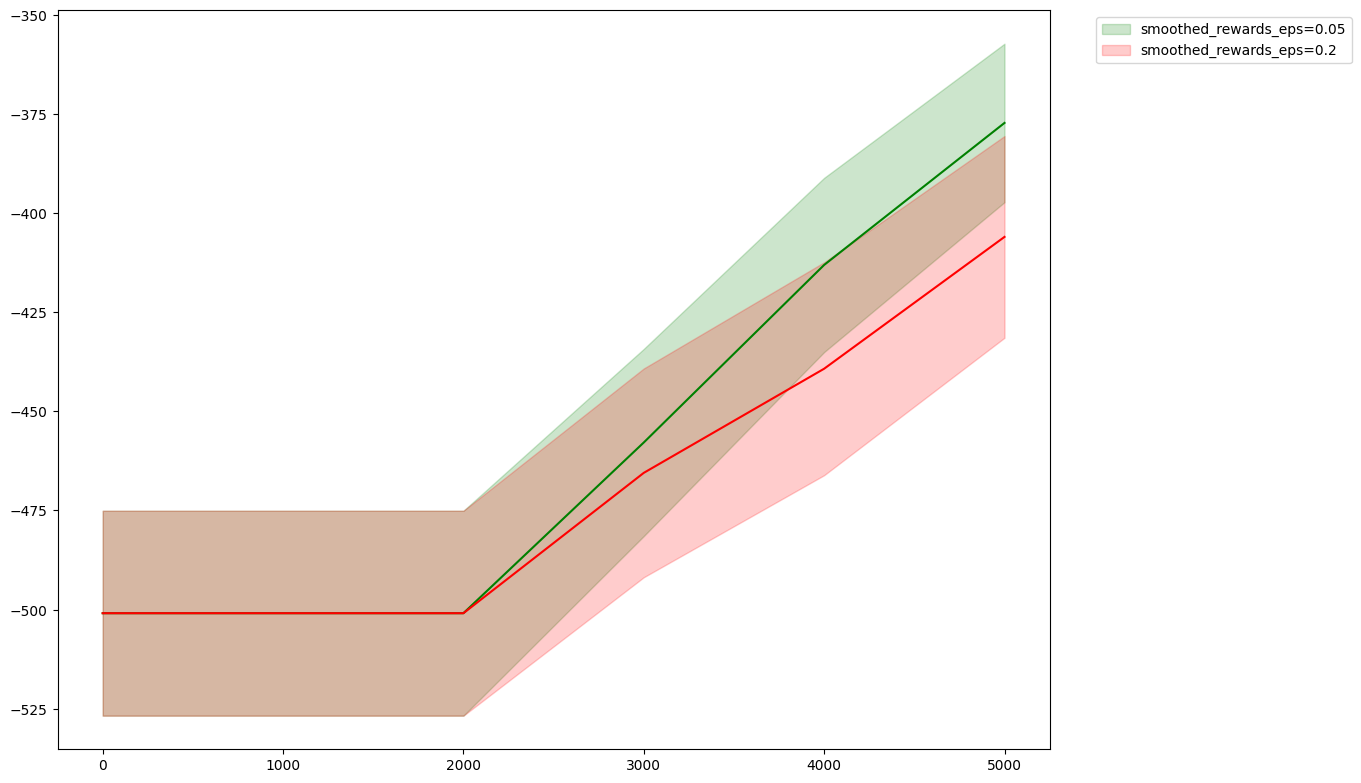

Training step: 0
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 5000
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 10000
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 15000
Eval mean: -51.188045708571295; eval_std: 0.7254303736598153
Training step: 20000
Eval mean: -18.849747440996094; eval_std: 0.027630491457092177
Training step: 25000
Eval mean: -19.766714710146932; eval_std: 48.99176089631737
[-500.91738789 -500.91738789 -500.91738789  -51.18804571  -18.84974744
  -19.76671471]
Training step: 0
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 5000
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 10000
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 15000
Eval mean: -81.39125434960036; eval_std: 2.735222326190126
Training step: 20000
Eval mean: -194.49739784063442; eval_std: 12.147302015661438
Training step: 25000
Eval me

<Figure size 640x480 with 0 Axes>

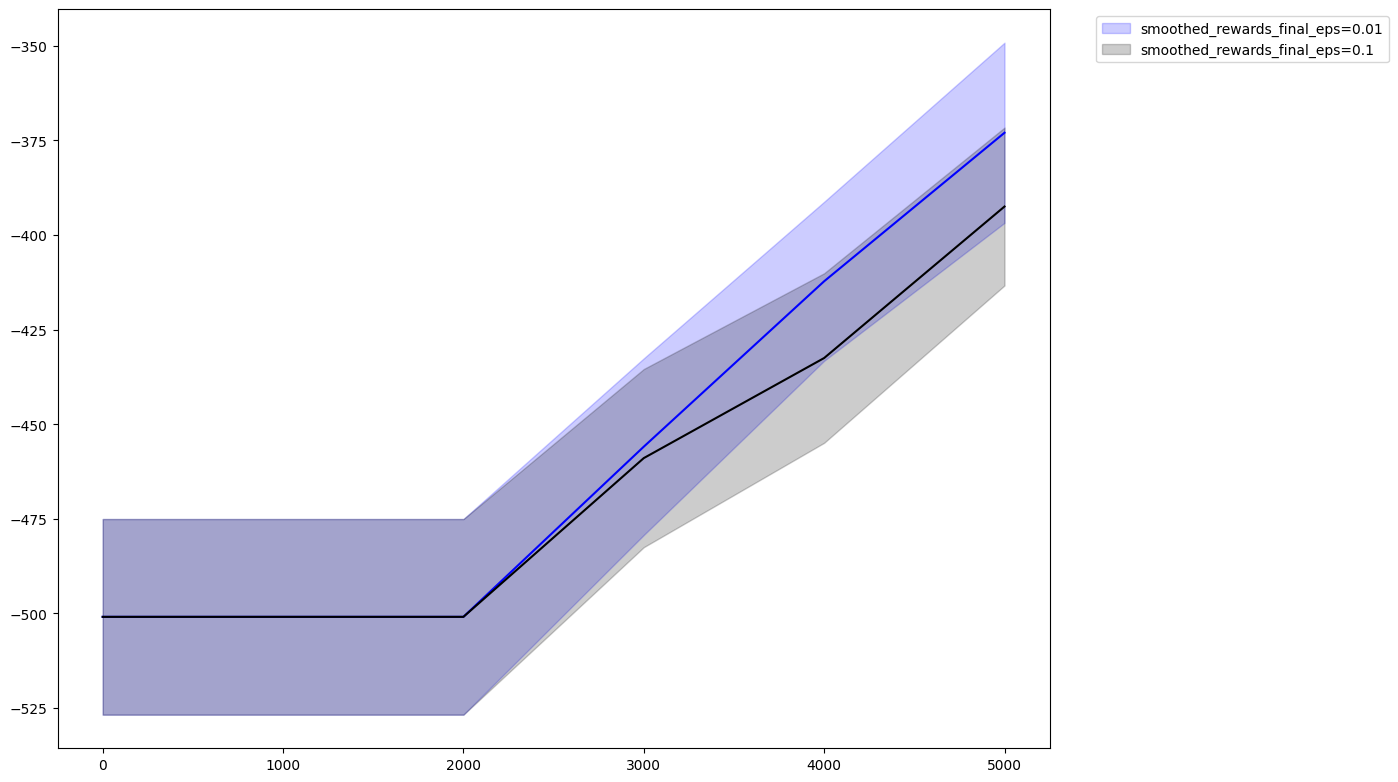

Training step: 0
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 5000
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 10000
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 15000
Eval mean: -108.0290617334772; eval_std: 7.821400137496823
Training step: 20000
Eval mean: -131.44916601247414; eval_std: 5.080260595991547
Training step: 25000
Eval mean: 1.3777601246477764; eval_std: 1.324637731536431
[-500.91738789 -500.91738789 -500.91738789 -108.02906173 -131.44916601
    1.37776012]
Training step: 0
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 5000
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 10000
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 15000
Eval mean: -108.9246762257205; eval_std: 0.30355731600246827
Training step: 20000
Eval mean: -60.0354014129193; eval_std: 0.3948074336285856
Training step: 25000
Eval mean: 14

<Figure size 640x480 with 0 Axes>

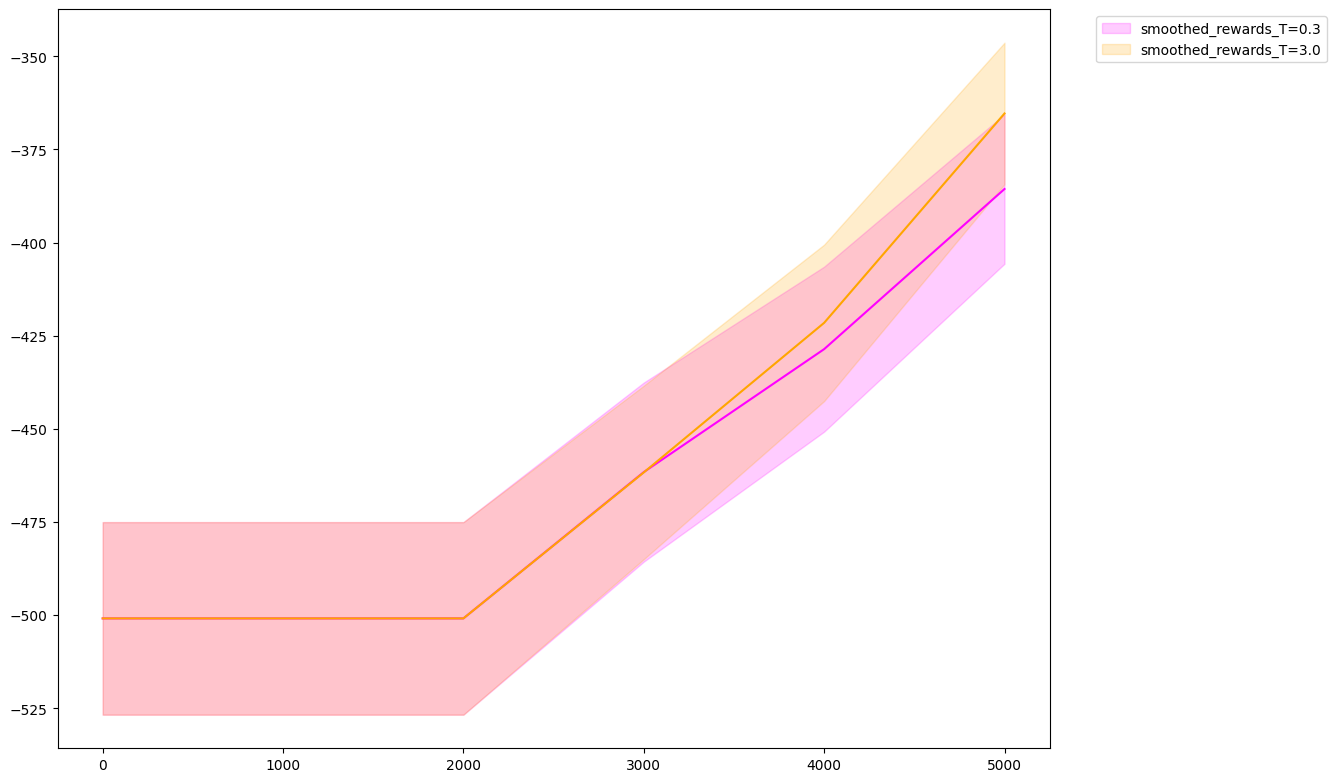

Training step: 0
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 5000
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 10000
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 15000
Eval mean: -63.062798689511666; eval_std: 8.683902695408648
Training step: 20000
Eval mean: -18.78880164285726; eval_std: 0.8641027802280785
Training step: 25000
Eval mean: 30.89373002836114; eval_std: 35.44295115527046
[-500.91738789 -500.91738789 -500.91738789  -63.06279869  -18.78880164
   30.89373003]
Training step: 0
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 5000
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 10000
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 15000
Eval mean: -141.29236269588074; eval_std: 16.742775522303518
Training step: 20000
Eval mean: -51.90400037105252; eval_std: 1.92817427452583
Training step: 25000
Eval mean: 96.

<Figure size 640x480 with 0 Axes>

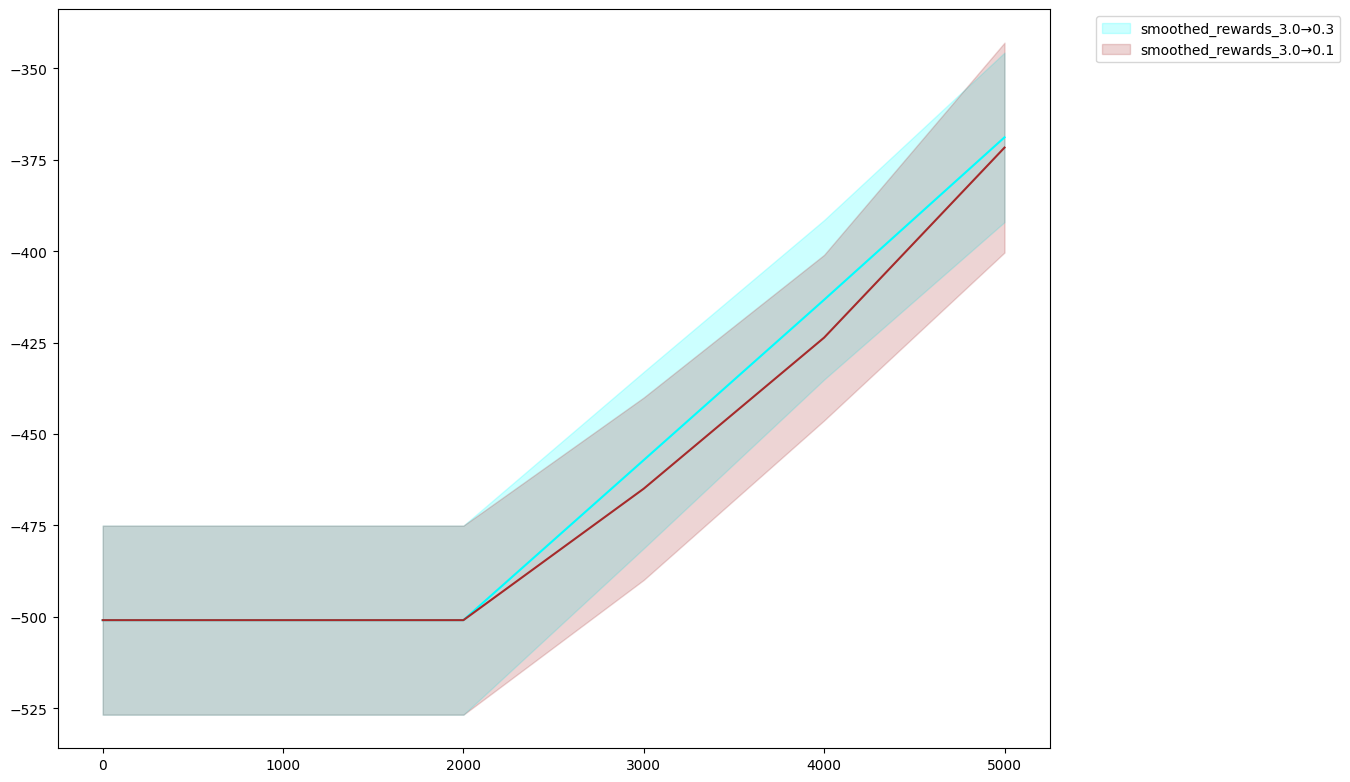

Training step: 0
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 5000
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 10000
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 15000
Eval mean: -128.8608954691502; eval_std: 17.714973135387154
Training step: 20000
Eval mean: -44.25684904759853; eval_std: 18.631214315116388
Training step: 25000
Eval mean: 89.60730664964312; eval_std: 7.129631404627787
[-500.91738789 -500.91738789 -500.91738789 -128.86089547  -44.25684905
   89.60730665]
Training step: 0
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 5000
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 10000
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 15000
Eval mean: -149.4003916647457; eval_std: 12.04542193876145
Training step: 20000
Eval mean: -29.41417960550742; eval_std: 4.348462877747892
Training step: 25000
Eval mean: 88.2

<Figure size 640x480 with 0 Axes>

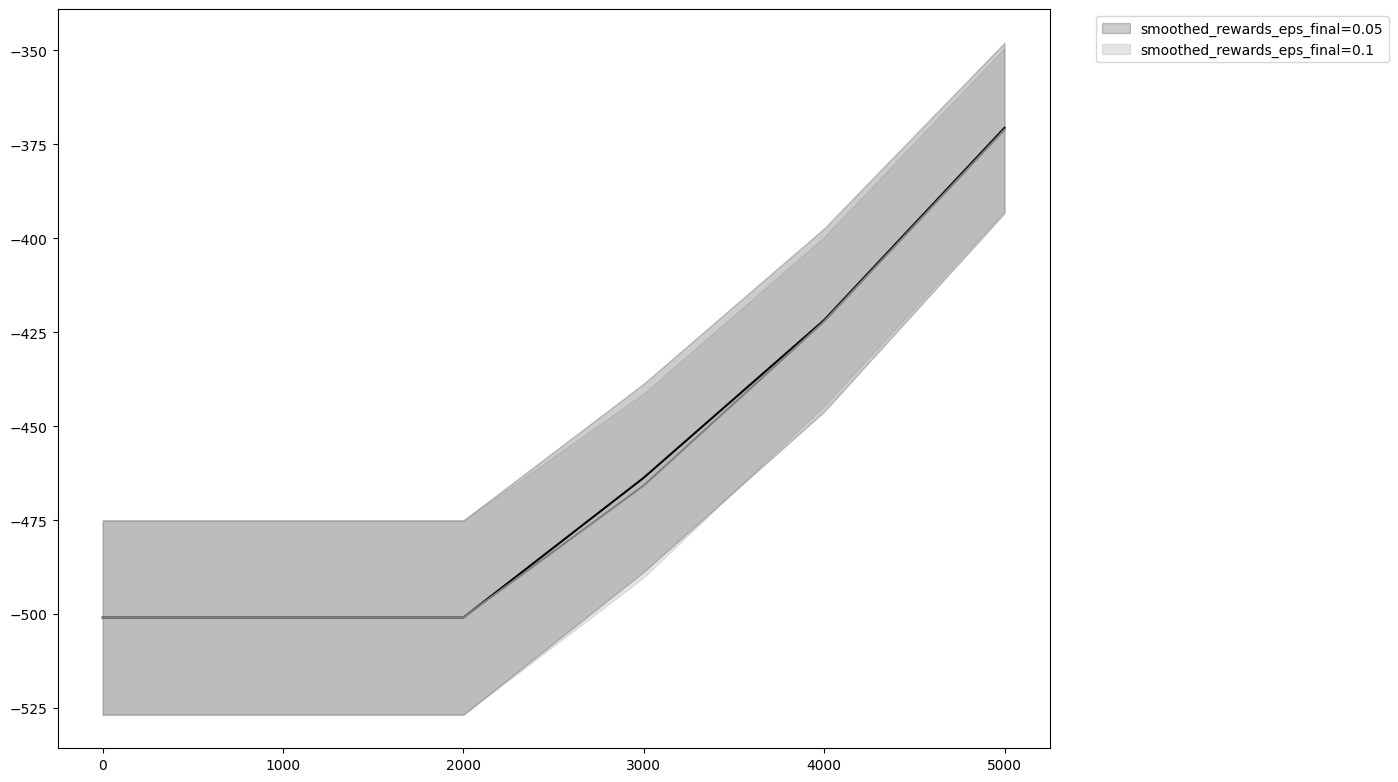

Training step: 0
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 5000
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 0
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 5000
Eval mean: 62.129971232939205; eval_std: 33.05096575960702
Training step: 10000
Eval mean: 146.42979010337615; eval_std: 1.615401946373936
Training step: 15000
Eval mean: 167.03157269642605; eval_std: 67.91507309369858
Training step: 20000
Eval mean: 200.57686837840004; eval_std: 46.07471440896569
Training step: 0
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 5000
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 10000
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 0
Eval mean: -11.60614144474773; eval_std: 0.2995256251100269
Training step: 5000
Eval mean: -22.660971773026247; eval_std: 1.0911195111180252
Training step: 10000
Eval mean: 174.7630805605633; 

<Figure size 640x480 with 0 Axes>

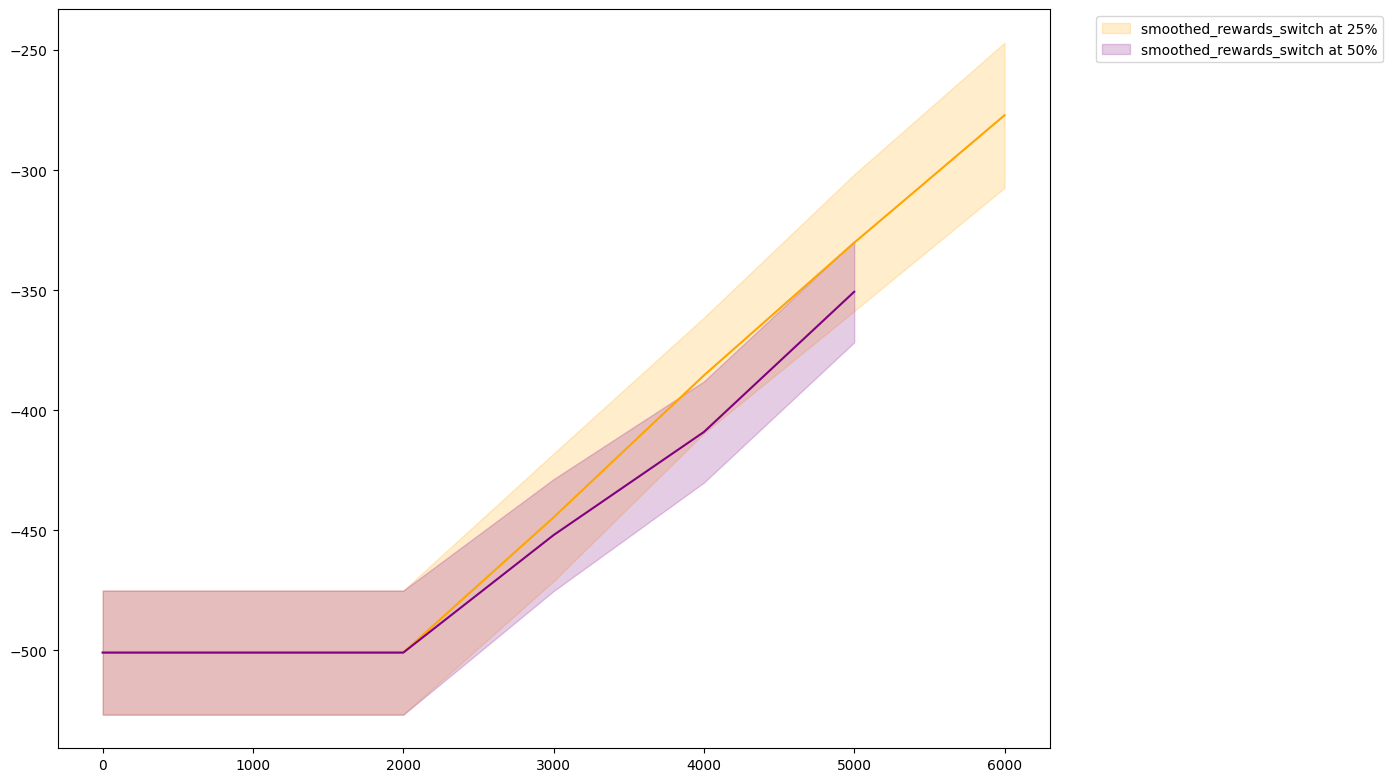

<Figure size 640x480 with 0 Axes>

In [24]:
screening_results = run_screening_all_families(args)

**Bonus exploration strategy.**

As an additional exploration method, I implemented a Boltzmann policy with adaptive temperature controlled by a target entropy. Instead of annealing the temperature as a function of time, the temperature is adjusted online to maintain a desired level of policy entropy. This allows the amount of exploration to automatically adapt to the quality and scale of the learned Q-values. When the policy becomes too deterministic, the temperature increases to encourage exploration; when it is too stochastic, the temperature decreases to favor exploitation. This approach removes the need for a manually tuned annealing schedule and provides a closed-loop mechanism for balancing exploration and exploitation.

In [29]:
class EntropyTargetBoltzmannDQN(DQN):
  """
  Bonus strategy:
  Boltzmann exploration where temperature is adapted to match a target entropy.
  If policy is too deterministic (entropy too low) -> increase T.
  If policy is too random (entropy too high) -> decrease T.
  """
  def __init__(self, args):
    super(EntropyTargetBoltzmannDQN, self).__init__(args)
    self.temperature = 1.0
    self.min_temperature = 0.05
    self.max_temperature = 5.0

    self.target_entropy = 0.8
    self.temp_lr = 0.05 # adaptation speed
    self.annealing = True

  def anneal(self, step):
    # Temperature is adapted inside explore() using the last observed entropy.
    pass

  def explore(self, states):
    with torch.no_grad():
      q_values = self.q_net(states)
      q_values = q_values - q_values.max(dim=-1, keepdim=True)[0]  # stabilize

      temp = max(self.temperature, 1e-8)
      probs = torch.softmax(q_values / temp, dim=-1)

      # Compute entropy per env: H(p) = -sum p log p
      entropy = -(probs * torch.log(probs + 1e-12)).sum(dim=-1)
      mean_entropy = float(entropy.mean().cpu().item())

      # Adapt temperature to push entropy towards target
      # If entropy < target -> increase T; if entropy > target -> decrease T
      self.temperature += self.temp_lr * (self.target_entropy - mean_entropy)
      self.temperature = float(np.clip(self.temperature, self.min_temperature, self.max_temperature))

      actions = torch.multinomial(probs, num_samples=1).squeeze(-1).cpu().numpy()

    return actions

We will evaluate the proposed entropy-targeted Boltzmann strategy using the same screening protocol as the baseline methods, with two different target entropy values.

**DISCLAIMER:**

Code for the test part was generated using Chat GPT.

Training step: 0
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 5000
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 10000
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 15000
Eval mean: -142.6228688616232; eval_std: 1.9725569443466355
Training step: 20000
Eval mean: -199.79092066729834; eval_std: 61.96829585472727
Training step: 25000
Eval mean: -69.3645460074338; eval_std: 3.5192985174532367
[-500.91738789 -500.91738789 -500.91738789 -142.62286886 -199.79092067
  -69.36454601]
Training step: 0
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 5000
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 10000
Eval mean: -500.9173878949357; eval_std: 25.852979469285174
Training step: 15000
Eval mean: -137.59983616992173; eval_std: 17.840111776506077
Training step: 20000
Eval mean: 36.898225541947205; eval_std: 37.44861778195578
Training step: 25000
Eval mean: 3

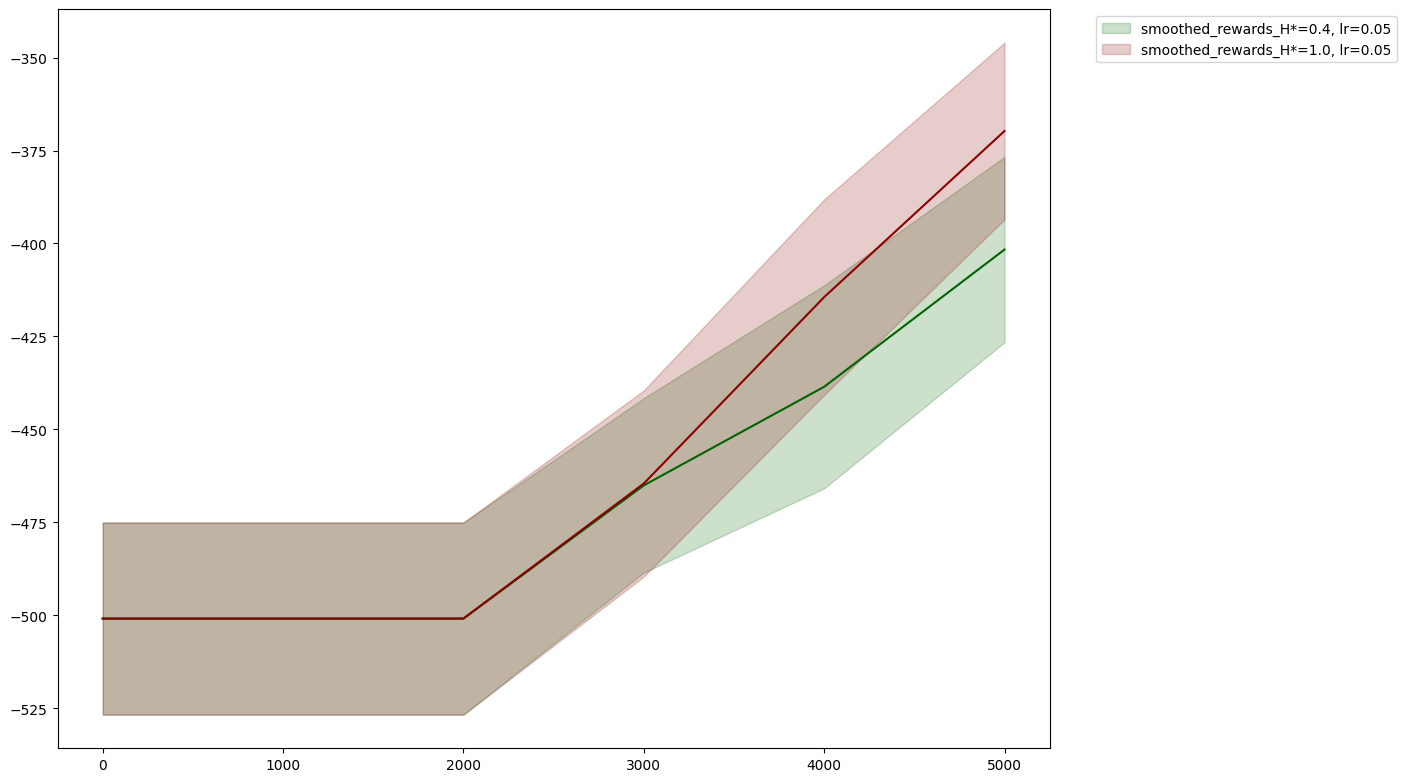

<Figure size 640x480 with 0 Axes>

In [28]:
def run_screening_bonus_entropy_boltzmann(base_args):
  """
  Screening for bonus method: Entropy-targeted Boltzmann
  Same setup as other screening experiments.
  """

  import copy

  def local_args():
    a = copy.deepcopy(base_args)
    a.n_training_steps = 30000
    a.eval_freq = 5000
    a.n_evaluate_episodes = 2
    a.n_seeds = 2
    return a

  runs = []

  configs = [
    {"target_entropy": 0.4, "temp_lr": 0.05},
    {"target_entropy": 1.0, "temp_lr": 0.05},
  ]

  for cfg in configs:
    a = local_args()
    dqn = EntropyTargetBoltzmannDQN(a)
    dqn.target_entropy = cfg["target_entropy"]
    dqn.temp_lr = cfg["temp_lr"]
    dqn.annealing = True

    means, stds = train_dqn(dqn)
    runs.append({
      "label": f"H*={cfg['target_entropy']}, lr={cfg['temp_lr']}",
      "means": means,
      "stds": stds
    })

  # plot bonus family
  plot_results_many(
    [r["means"] for r in runs],
    [r["stds"] for r in runs],
    [r["label"] for r in runs],
    ["darkgreen", "darkred"]
  )

  return runs

bonus_results = run_screening_bonus_entropy_boltzmann(args)

**Overall conclusions**

The screening shows that the choice of exploration strategy has a significant impact on learning speed and stability in the LunarLander environment. Fixed random and simple epsilon-greedy strategies perform poorly under a limited training budget, remaining highly suboptimal for most of the training. Annealing-based approaches consistently outperform fixed-parameter methods, indicating that **gradually reducing exploration is crucial for effective learning**. Boltzmann-based strategies demonstrate faster performance improvements once the Q-function becomes informative, but their effectiveness is sensitive to temperature settings. Max-Boltzmann and strategy-switching approaches further improve robustness by combining greedy action selection with stochastic exploration. The proposed entropy-targeted Boltzmann strategy achieves competitive performance during screening and demonstrates that adaptive, feedback-driven control of exploration can be a viable alternative to manually designed annealing schedules.

**Selection for final evaluation.**

Based on the screening results, two strategies were selected for full-scale evaluation. First, the max-Boltzmann strategy with annealing was chosen as the strongest baseline, as it consistently achieved positive average returns and showed stable convergence across runs. Second, the entropy-targeted Boltzmann strategy was selected as the proposed bonus method, since it reached comparable performance while dynamically adapting the amount of exploration without relying on a predefined temperature schedule. These two methods represent different design philosophies - manual schedule-based control versus adaptive entropy-based control - thus provide an informative comparison for the final evaluation phase.

Training step: 0
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 1000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 2000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 3000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 4000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 5000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 6000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 7000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 8000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 9000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 10000
Eval mean: -639.6903477514232; eval_std: 59.38467170955477
Training step: 11000
Eval mean: -90.66936417175452; eval_std: 8.05155217394825
Training step: 12000
Eval mean: -95.94414525621293; ev

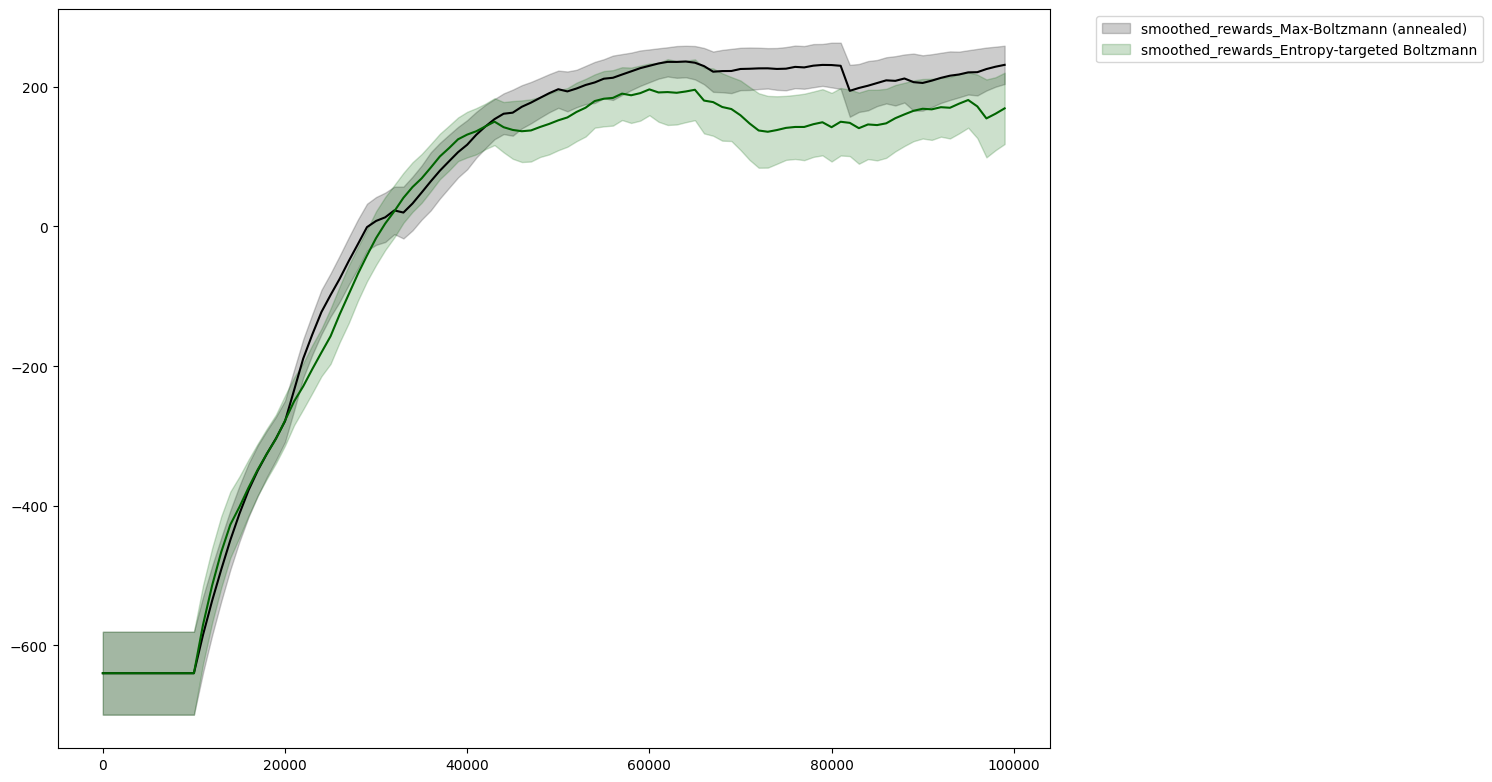

<Figure size 640x480 with 0 Axes>

In [31]:
def run_final_comparison_best_two(args):
  """
  Final evaluation of the two best methods:
  1) Max-Boltzmann with annealing
  2) Entropy-targeted Boltzmann (bonus)
  """

  import copy

  results = []

  max_boltz = MaxBoltzmannDQN(args)
  max_boltz.temperature = 1.0
  max_boltz.start_epsilon = 1.0
  max_boltz.final_epsilon = 0.1
  max_boltz.anneal_steps = args.n_training_steps
  max_boltz.annealing = True

  means, stds = train_dqn(max_boltz)
  results.append({
    "label": "Max-Boltzmann (annealed)",
    "means": means,
    "stds": stds
  })

  entropy_boltz = EntropyTargetBoltzmannDQN(args)
  entropy_boltz.target_entropy = 0.8
  entropy_boltz.temp_lr = 0.05
  entropy_boltz.annealing = True

  means, stds = train_dqn(entropy_boltz)
  results.append({
    "label": "Entropy-targeted Boltzmann",
    "means": means,
    "stds": stds
  })

  plot_results_many(
    [r["means"] for r in results],
    [r["stds"] for r in results],
    [r["label"] for r in results],
    ["black", "darkgreen"]
  )

  return results

final_results = run_final_comparison_best_two(args)

**Results:**

These learning curves show a typical DQN "breakthrough" pattern: for roughly the first ~10k steps the agent performs at a near-constant very low return (≈ −640), indicating mostly unproductive behavior while the replay buffer is being filled and the Q-function is still poorly shaped. After that point, performance improves rapidly and then stabilizes around the ~170-230 range, which is consistent with reaching a near-solved LunarLander policy. The first run reaches higher peaks earlier (frequently >200 and up to ~240+) and maintains a steadier plateau, while the second run improves more gradually and appears noisier (higher late-stage standard deviations and more fluctuation), suggesting slightly less stable learning under that configuration/seed. Overall, both runs converge to strong performance, with the first configuration showing better sample-efficiency and stability.

Therefore, **the Max-Boltzmann strategy** with annealing turns out to be the most performant of all the implemented approaches.